In [ ]:
!pip install opendatasets

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp

from urllib.parse import urlparse

import opendatasets as od
import os

import cv2
from skimage import exposure

In [ ]:
od.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pierrejeancornejo
Your Kaggle Key: ··········


100%|██████████| 778M/778M [00:07<00:00, 117MB/s]


In [ ]:
COVID_metadata = pd.read_excel('/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx')
Lung_Opacity_metadata = pd.read_excel('/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx')
Normal_metadata = pd.read_excel('/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx')
Pneumonia_metadata = pd.read_excel('/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx')

In [ ]:
df_metadata = pd.concat([COVID_metadata, Lung_Opacity_metadata, Normal_metadata, Pneumonia_metadata], ignore_index = True)

In [ ]:
#PJ - extraction du type de radiogrpahie ( Normal, Lung_opacity, COVID et viral pneumonia) et ajout au df des metadata
df_metadata["Type"] = df_metadata["FILE NAME"].str.split('-', n=1).str.get(0)
df_metadata["Type"].value_counts()

NORMAL             10192
Lung_Opacity        6012
COVID               3616
Viral Pneumonia     1345
Name: Type, dtype: int64

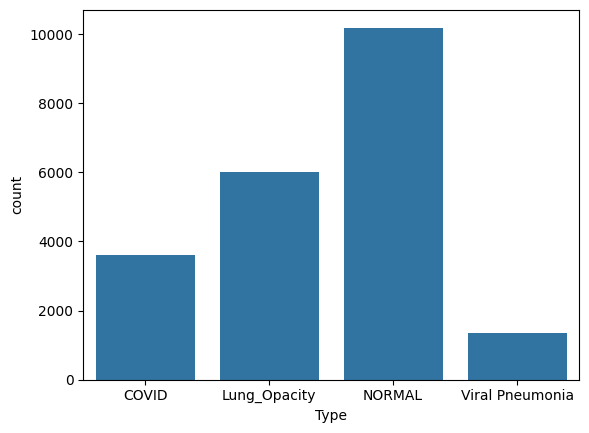

In [ ]:
#PJ - countplot du nombre d'image par condition
sns.countplot(x="Type", data=df_metadata)
plt.show()

In [ ]:
#PJ - extraction du nom des sites internet d'où provienne les radio d'après les metadata

#fonction pour récupérer le nom de domaine // utilisation de la librairie urllib
def extract_domain(url):
    parsed_url = urlparse(url)
    return parsed_url.netloc

#application de la fonction au df des metadata
df_metadata['site'] = df_metadata['URL'].apply(extract_domain)

df_metadata

,FILE NAME,FORMAT,SIZE,URL,Type,site
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID,sirm.org
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID,sirm.org
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID,sirm.org
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID,sirm.org
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID,sirm.org
...,...,...,...,...,...,...
21160,Viral Pneumonia-1341,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia,www.kaggle.com
21161,Viral Pneumonia-1342,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia,www.kaggle.com
21162,Viral Pneumonia-1343,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia,www.kaggle.com
21163,Viral Pneumonia-1344,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia,www.kaggle.com


Text(0.5, 0.98, 'Provenance des images pour chaque type de radiographie')

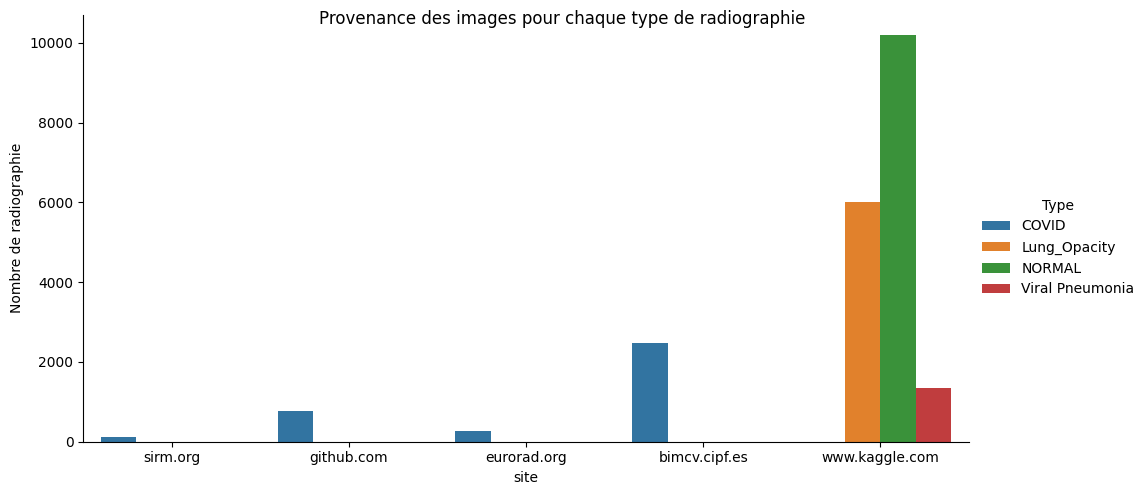

In [ ]:

#PJ-Quantif de la provenance des radio
g = sns.catplot(x="site", kind="count", hue="Type", data=df_metadata, aspect=2)
g.set_axis_labels("site", "Nombre de radiographie")
g.fig.suptitle("Provenance des images pour chaque type de radiographie")

In [ ]:

#PJ - Chemin des dossiers contenant les images
dossiers = [r"/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images",
            r"/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images",
            r"/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images",
            r"/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"]


#Liste vide pour stocker les 4 dossiers
Liste_dossiers = []


# premiere boucle pour recréer le nom de chaque image par dossier / noms stockés dans 'images_dossier'
for dossier in dossiers:
    images_dossier = [f for f in os.listdir(dossier) if f.endswith('.png')]
    Liste_images = []

#deuxieme boucle pour recréer le chemin de chaque image, l'importer en 8bit, et la stocker
#dans liste_dossier -> list_image
    for image_file in images_dossier:
        image_path = os.path.join(dossier, image_file)
        image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
        Liste_images.append(image_gray)

    Liste_dossiers.append(Liste_images)



In [ ]:
print(len(Liste_dossiers)) # liste des 4 "dossiers" de départ
print(len(Liste_dossiers[0]))  # liste qui contient les array des images "normales"
print(len(Liste_dossiers[1]))  # liste qui contient les array des images "viral pneumonia"
print(len(Liste_dossiers[2]))  # liste qui contient les array des images "Lung opacity"
print(len(Liste_dossiers[3]))  # liste qui contient les array des images "COVID"

4
10192
1345
6012
3616


In [ ]:

#PJ - Normalisation de l'intensité des images, utilisation de la librairie skimage
normalized_images_groups = []

for group in Liste_dossiers:
    normalized_group = [exposure.rescale_intensity(image_array, in_range=(np.min(image_array), np.max(image_array)), out_range=(0, 255)).astype(np.uint8) for image_array in group]
    normalized_images_groups.append(normalized_group)



In [ ]:
#PJ - Calcul de l'image moyenne normalisée pour chaque groupe
mean_images_normalized = [np.mean(normalized_group, axis=0) for normalized_group in normalized_images_groups]


In [ ]:
#PJ -  Calcul de l'ecart type pour chaque groupe
std_images_normalized = [np.std(normalized_group, axis=0) for normalized_group in normalized_images_groups]

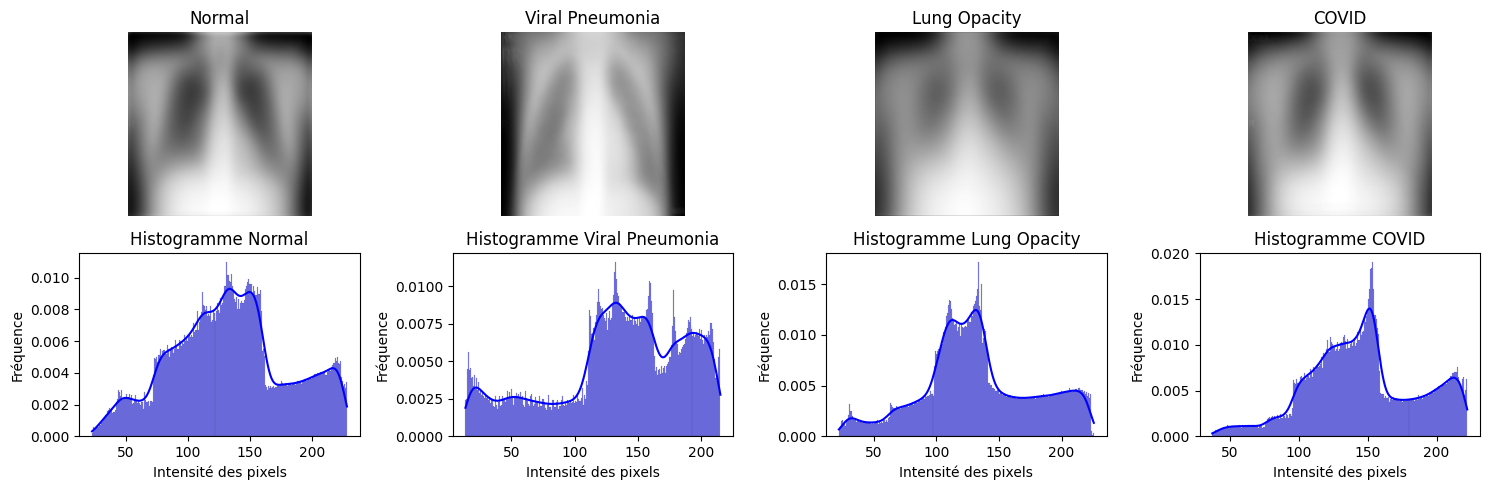

In [ ]:
#PJ - Affichage de l'image "moyenne" par condition

labels = ["Normal", "Viral Pneumonia", "Lung Opacity", "COVID"]


plt.figure(figsize=(15, 5))

# Afficher les images moyennes
for i, mean_image in enumerate(mean_images_normalized):
    plt.subplot(2, 4, i+1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(labels[i])
    plt.axis('off')

    # Afficher l'histogramme de l'intensité des pixels
    plt.subplot(2, 4, i+5)
    sns.histplot(mean_image.flatten(), bins=256, kde=True, color='blue', stat='density', common_norm=False)
    plt.title(f'Histogramme {labels[i]}')
    plt.xlabel('Intensité des pixels')
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()


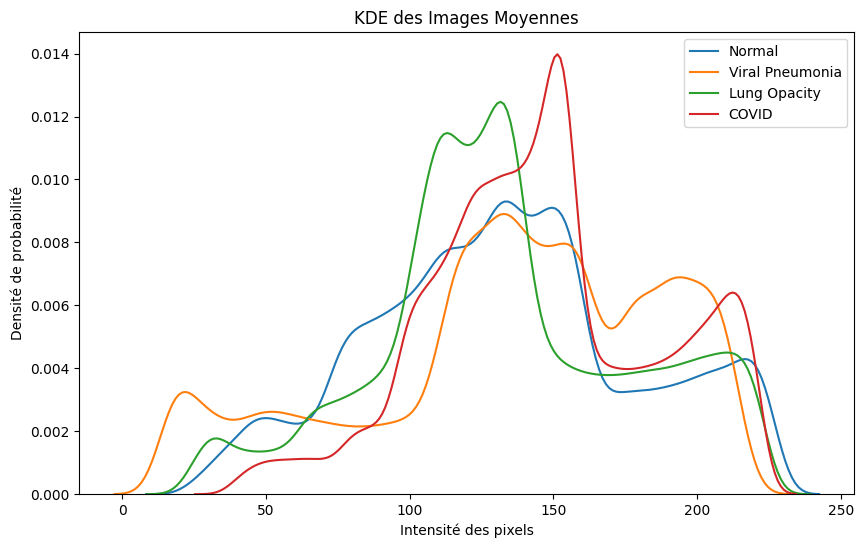

In [ ]:
#PJ - Affichage superposé des KDE des image moyennes

plt.figure(figsize=(10, 6))

for i, mean_image in enumerate(mean_images_normalized):
    sns.kdeplot(mean_image.flatten(), label=f'{labels[i]}')

plt.title('KDE des Images Moyennes')
plt.xlabel('Intensité des pixels')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.show()

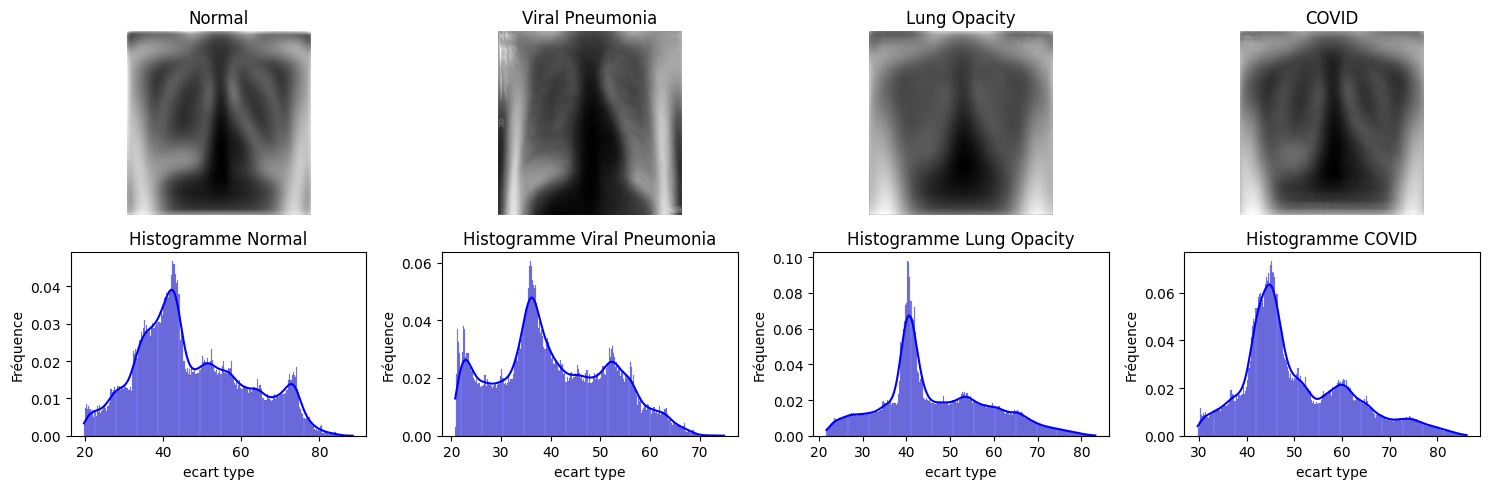

In [ ]:
#PJ - Affichage de l'écart type par condition


plt.figure(figsize=(15, 5))

# Afficher les images ecart type
for i, std_image in enumerate(std_images_normalized):
    plt.subplot(2, 4, i+1)
    plt.imshow(std_image, cmap='gray')
    plt.title(labels[i])
    plt.axis('off')

    # Afficher l'histogramme de l'intensité des pixels
    plt.subplot(2, 4, i+5)
    sns.histplot(std_image.flatten(), bins=256, kde=True, color='blue', stat='density', common_norm=False)
    plt.title(f'Histogramme {labels[i]}')
    plt.xlabel('ecart type')
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

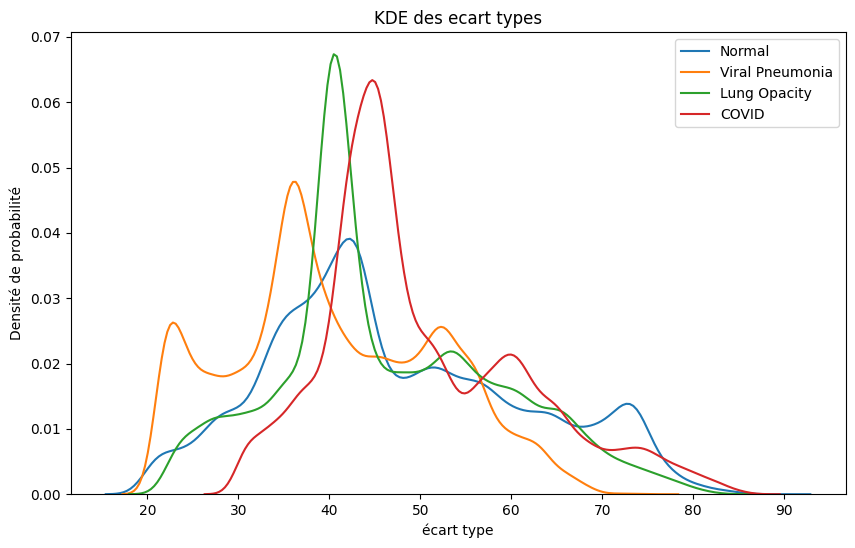

In [ ]:
#PJ - Affichage superposé des KDE des écart types

plt.figure(figsize=(10, 6))

for i, std_image in enumerate(std_images_normalized):
    sns.kdeplot(std_image.flatten(), label=f'{labels[i]}')

plt.title('KDE des ecart types')
plt.xlabel('écart type')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.show()